In [1]:
import pickle
from pathlib import Path

import lanfactory
import sbibm
import torch

from sbi.inference import MCMCPosterior, MNLE
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import mcmc_transform
from sbi.analysis import pairplot


2022-04-29 09:17:18.056956: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2022-04-29 09:17:18.056982: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Get benchmark task to load observations
seed = torch.randint(100000, (1,)).item()

task = sbibm.get_task("ddm")
prior = task.get_prior_dist()
simulator = task.get_simulator(seed=seed) # Passing the seed to Julia.

In [3]:
# Observation indices >200 hold 100-trial observations
num_obs = 100
xos = torch.stack([task.get_observation(200 + ii) for ii in range(1, 1+num_obs)]).squeeze()

# encode xos as (time, choice)
xos_2d = torch.zeros((xos.shape[0], xos.shape[1], 2))
for idx, xo in enumerate(xos):
    xos_2d[idx, :, 0] = abs(xo)
    xos_2d[idx, xo > 0, 1] = 1

In [4]:
BASE_DIR = Path.cwd().parent.parent
save_folder = BASE_DIR / "data/results"

In [5]:
with open("lan_10_11_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples1 = torch.stack(samples)

with open(save_folder / "lan_10_5_ours_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples2 = torch.stack(samples)

with open(save_folder / "lan_10_6_ours_posterior_samples_100x100iid.p", "rb") as fh:
    samples = pickle.load(fh)
samples3 = torch.stack(samples)




FileNotFoundError: [Errno 2] No such file or directory: 'lan_10_11_posterior_samples_100x100iid.p'

In [6]:
# Reference posterior for first obs in xos
obsi = 18
reference_samples = task.get_reference_posterior_samples(201+obsi)
true_theta = task.get_true_parameters(201+obsi)

fig, ax = pairplot(
    [
        reference_samples[:1000], 
        samples1[obsi,], 
        # samples2[obsi,],
        samples3[obsi,], 
    ], 
    upper="contour", points=true_theta, figsize=(18, 10),
    contour_offdiag = dict(levels=[0.99]),
    limits=[[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
    ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [.2, 1.8]], 
);

NameError: name 'samples1' is not defined

## Inference with gradient information: HMC-NUTS

In [7]:
# load a LAN
budget = "100000"
model_path = Path.cwd() / f"models/"
network_file_path = list(model_path.glob(f"mnle_n{budget}_new*"))[5]  # take first model from random inits.

with open(network_file_path, "rb") as fh:
    mnle, *_ = pickle.load(fh).values()

mcmc_parameters = dict(
    warmup_steps = 100, 
    thin = 10, 
    num_chains = 2,
    num_workers = 1,
    init_strategy = "sir",
    )
mcmc_method = "nuts"

# Build MCMC posterior in SBI.
mnle_posterior = MNLE().build_posterior(mnle, prior, 
    mcmc_method=mcmc_method, 
    mcmc_parameters=mcmc_parameters,
    )

samples = []
num_samples = 10000

viposterior = MNLE().build_posterior(mnle, prior, 
    sample_with="vi"
    )

In [15]:
obsi = 10
xo = xos_2d[obsi]
viposterior.set_default_x(xo)
viposterior.train(max_num_iters=500)
vi_samples = viposterior.sample((num_samples, ))

with open(f"mnle_vi_samples_obs{201+obsi}.p", "wb") as fh:
    pickle.dump(vi_samples, fh)

  0%|          | 0/500 [00:00<?, ?it/s]


Converged with loss: 54.19
Quality Score: -0.013 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


In [8]:
with open(save_folder / "mnle_samplemethod_comparison_obs211.p", "rb") as fh:
    reference_samples, true_theta, slice_samples, vi_samples, nuts_samples, timings = pickle.load(fh).values()

/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/janfb/qode/sbi/sbi/analysis/plot.py:425: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],


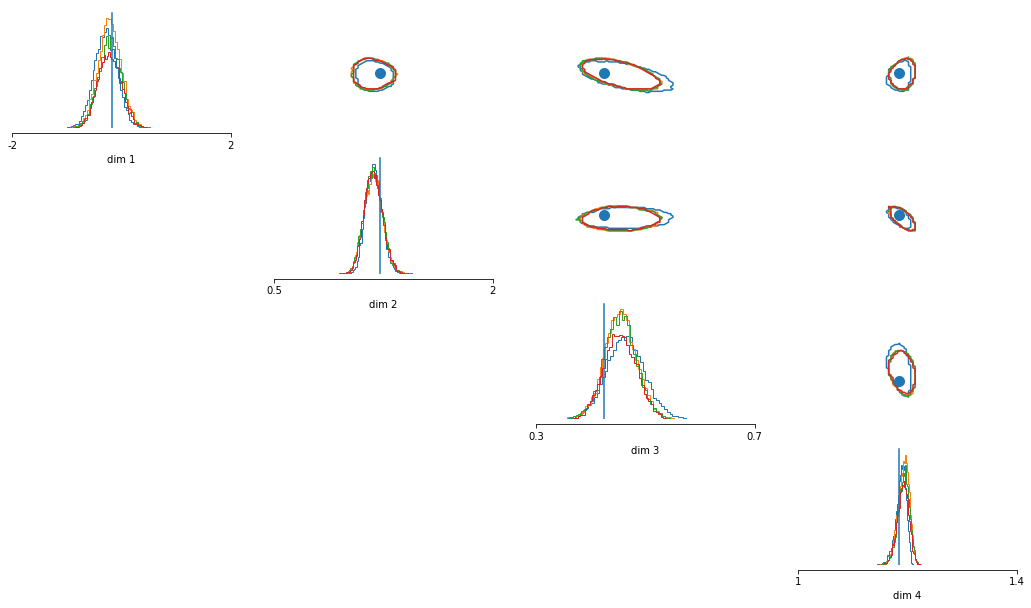

In [9]:
fig, ax = pairplot(
    [
        reference_samples, 
        slice_samples,
        nuts_samples, 
        vi_samples,
    ], 
    kde_offdiag=dict(bw_method=0.2, bins=100),
    kde_diag=dict(bw_method=0.12, bins=100),
    upper="contour", 
    points=true_theta, figsize=(18, 10),
    contour_offdiag = dict(levels=[0.95]),
    limits=[[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
    ticks = [[-2, 2], [0.5, 2.0], [.3, .7], [1., 1.4]], 
);

In [10]:
timings

{'vi': 23.412761211395264,
 'slice': 1037.4737348556519,
 'nuts': 4300.829827308655}

In [11]:
from sbi.utils.metrics import c2st

In [12]:
c2st(vi_samples, reference_samples)

tensor([0.5918])

In [13]:
c2st(reference_samples, slice_samples)

tensor([0.6102])

In [14]:
c2st(reference_samples, nuts_samples)

tensor([0.6146])

In [13]:
c2st(vi_samples, slice_samples)

tensor([0.5257])

In [14]:
c2st(vi_samples, nuts_samples)

tensor([0.5189])

In [15]:
c2st(slice_samples, nuts_samples)

tensor([0.5040])